In [34]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize_scalar
import jax
import jax.numpy as jnp
import haiku as hk
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [35]:
import scipy as sp
def f(z, *args):
    y, xi, chi = args
    return float(y != np.sign(z)) + (z - xi) ** 2 / (2 * chi)

z = np.random.randn(1)
y = 1
xi = np.random.randn(1)
chi = 0.1
res = sp.optimize.minimize(f, z, (y, xi, chi))

In [36]:
def eqn_sp(alpha):
    def f_z(z, *args):
        y, xi, chi = args
        return (y != np.sign(z)).astype(z.dtype) + (z - xi) ** 2 / (2 * chi)

    def extr(chi):
        term1 = -1 / (2 * chi)
        term2 = alpha * 0.5 * (
            sp.integrate.quad(
                lambda xi: np.exp(-0.5 * xi ** 2) / np.sqrt(2 * np.pi) * minimize_scalar(f_z, args=(1, xi, chi)).fun,
                a=-np.inf, b=np.inf
            )[0]
            + sp.integrate.quad(
                lambda xi: np.exp(-0.5 * xi ** 2) / np.sqrt(2 * np.pi) * minimize_scalar(f_z, np.random.randn(1), args=(-1, xi, chi)).fun,
                a=-np.inf, b=np.inf
            )[0]
        )
        e_gs = term1 + term2
        return e_gs
    
    bar = tqdm()
    e_gs = sp.optimize.minimize(lambda chi: -extr(chi), x0=1 / np.sqrt(alpha), callback=lambda _: bar.update()).fun
    bar.close()
    return 1 - 2 / alpha * (-e_gs)

In [37]:
# alphas = np.linspace(1e-3, 20, 10)
# res = [eqn_sp(a) for a in tqdm(alphas)]
# res = [x / max(res) for x in res]

In [38]:
# plt.plot(alphas, res)

In [39]:
def eqn_sp_np(alpha, xi_n=10**4, aux_n=10**2):

    def f_z(z, y, xi, chi):
        return (y != np.sign(z)).astype(np.float32) + (z - xi) ** 2 / (2 * chi)

    def extr(chi):
        term1 = -1 / (2 * chi)
        term2 = 0
        for y in [1, -1]:
            s = 0
            for _ in range(aux_n):
                xi = np.random.randn(xi_n)
                z = np.random.randn(xi_n, xi_n)
                min_z = np.amin(f_z(z, y, xi, chi), axis=0)
                s += np.sum(min_z) / xi_n
            term2 += s / aux_n * 0.5
        term2 = alpha * term2
        e_gs = term1 + term2
        return e_gs

    print(alpha)
    res = sp.optimize.minimize(lambda chi: -extr(chi), 1 / np.sqrt(alpha), bounds=[(1e-9, 1)])
    print(res)
    rademacher = 1 - 2 / alpha * (-res.fun)
    print(rademacher)
    return rademacher

In [40]:
# alphas = np.linspace(1e-3, 20, 10)
# res = [eqn_sp_np(a) for a in tqdm(alphas)]

In [41]:
# plt.plot(alphas, res)

In [42]:
def eqn_sp_jax(alpha, xi_n=10**4, aux_n=10**2):
    key_seq = hk.PRNGSequence(42)
    key_seq.reserve_up_to_full()

    @jax.jit
    def f_z(z, y, xi, chi):
        return (y != jnp.sign(z)).astype(jnp.float32) + (z - xi) ** 2 / (2 * chi)

    def extr(chi):
        term1 = -1 / (2 * chi)
        term2 = 0
        for y in [1, -1]:
            s = 0
            for _ in range(aux_n):
                key_z = next(key_seq)
                key_xi = next(key_seq)
                z = jax.random.normal(key_z, (xi_n, xi_n))
                xi = jax.random.normal(key_xi, (xi_n,))
                _y = jnp.full((1,), y)
                _chi = jnp.full((1,), chi)
                min_z = f_z(z, _y, xi, _chi).min(axis=0)
                s += min_z.sum() / xi_n
            term2 += s / aux_n * 0.5
        term2 = alpha * term2
        e_gs = term1 + term2
        return e_gs

    print(alpha)
    res = sp.optimize.minimize(lambda chi: -extr(chi), 1 / np.sqrt(alpha), bounds=[(1e-9, 1)])
    print(res)
    rademacher = 1 - 2 / alpha * (-res.fun)
    print(rademacher)
    return rademacher

In [43]:
# def eqn_sp_jax(alpha, xi_n=10**4, aux_n=10**2):
#     key_seq = hk.PRNGSequence(42)
#     key_seq.reserve_up_to_full()

#     @jax.jit
#     def body(y, xi, chi, key):
#         z = jax.random.normal(key, (xi_n,))
#         min_z = jnp.amin((y != jnp.sign(z)).astype(jnp.float32) + (z - xi) ** 2 / (2 * chi))
#         return min_z

#     def extr(chi):
#         term1 = -1 / (2 * chi)
#         term2 = 0
#         for y in [1, -1]:
#             s = 0
#             for _ in range(aux_n):
#                 key_z = next(key_seq)
#                 keys = jax.random.split(key_z, xi_n)
#                 min_z = jax.vmap(body)(jnp.full((xi_n,), y), jax.random.normal(key_z, (xi_n,)), jnp.full((xi_n,), chi), keys)
#                 s += jnp.sum(min_z) / xi_n
#             term2 += s / aux_n * 0.5
#         term2 = alpha * term2
#         e_gs = term1 + term2
#         return e_gs

#     print(alpha)
#     res = sp.optimize.minimize(lambda chi: -extr(chi), 1 / np.sqrt(alpha), bounds=[(1e-9, 1)])
#     print(res)
#     rademacher = 1 - 2 / alpha * (-res.fun)
#     print(rademacher)
#     return rademacher

In [44]:
alphas = np.linspace(0.5, 10, 30)
res = [eqn_sp_jax(a) for a in alphas]

0.5
      fun: 0.4072454869747162
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([330.80577684])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 2
     njev: 18
   status: 0
  success: True
        x: array([0.99999602])
2.6289819478988647
0.8275862068965517
      fun: 0.3464739918708801
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([545.38249695])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 2
     njev: 18
   status: 0
  success: True
        x: array([0.99999603])
1.8373121470212936
1.1551724137931034
      fun: 0.31418609619140625
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-643.73016034])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 2
     njev: 18
   status: 0
  success: True
        x: array([0.93041586])
1.5439639874358675
1.4827586206896552
      fun: 0.30257830023765564
 hess_

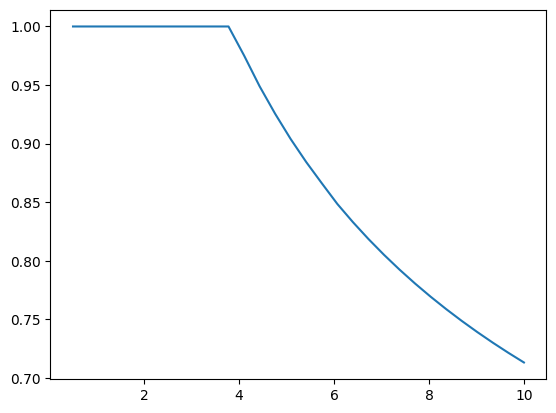

In [57]:
plt.plot(alphas, np.clip(res, a_min=None, a_max=1))

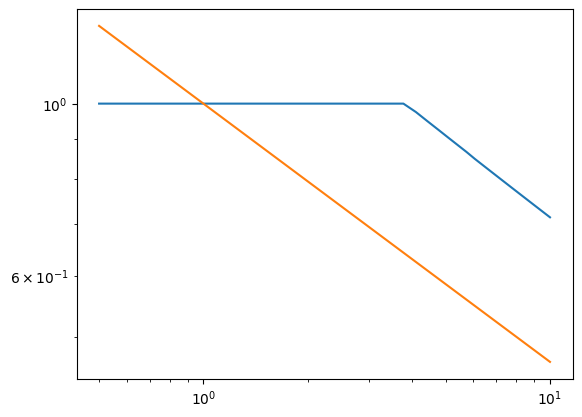

In [56]:
plt.loglog(alphas, np.clip(res, a_min=None, a_max=1))
plt.loglog(alphas, alphas ** (-1/3))

In [ ]:
def eqn_jax(alpha, chi_n=10**2, xi_n=10**4, aux_n=10**2):
    key_seq = hk.PRNGSequence(42)
    key_seq.reserve_up_to_full()

    @jax.jit
    def body(y, xi, chi, key):
        z = jax.random.normal(key, (xi_n,))
        min_z = jnp.amin((y != jnp.sign(z)).astype(jnp.float32) + (z - xi) ** 2 / (2 * chi))
        return min_z

    def extr(chi):
        term1 = -1 / (2 * chi)
        term2 = 0
        for y in [1, -1]:
            s = 0
            for _ in range(aux_n):
                key_z = next(key_seq)
                keys = jax.random.split(key_z, xi_n)
                min_z = jax.vmap(body)(jnp.full((xi_n,), y), jax.random.normal(key_z, (xi_n,)), jnp.full((xi_n,), chi), keys)
                s += jnp.sum(min_z) / xi_n
            term2 += s / aux_n
        term2 = alpha / 2 * term2
        e_gs = term1 + term2
        return e_gs
    
    best_e_gs = 0
    for chi in tqdm(np.linspace(1e-9, 1, chi_n)):
        e_gs = extr(chi)
        print(e_gs)
        if e_gs > best_e_gs:
            best_e_gs = e_gs
    print(best_e_gs)
    return 1 - 2 / alpha * best_e_gs

In [ ]:
# alphas = np.linspace(1e-3, 5, 10)
# res = [eqn1(a) for a in alphas]

In [ ]:
# plt.plot(alphas, [x / max(res) for x in res])